In [204]:
!wget https://camo.githubusercontent.com/7a19800e22d83bf05adc5537789eff0f870b3e1b/68747470733a2f2f692e696d6775722e636f6d2f375158677856592e706e67

--2018-06-04 10:47:11--  https://camo.githubusercontent.com/7a19800e22d83bf05adc5537789eff0f870b3e1b/68747470733a2f2f692e696d6775722e636f6d2f375158677856592e706e67
Resolving camo.githubusercontent.com (camo.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to camo.githubusercontent.com (camo.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 672634 (657K) [image/png]
Saving to: ‘68747470733a2f2f692e696d6775722e636f6d2f375158677856592e706e67’

68747470733a2f2f692 100%[===================>] 656.87K  --.-KB/s    in 0.1s    

2018-06-04 10:47:12 (6.38 MB/s) - ‘68747470733a2f2f692e696d6775722e636f6d2f375158677856592e706e67’ saved [672634/672634]



In [233]:
from PIL import Image
im = Image.open("./test_images/traffic_y.png")
im.convert('RGB').save("./test_images/traffic_y.jpg","JPEG") #this converts png image as jpeg

In [234]:
!ls ./test_images/

1*AcigwfSCTELcCOp912IV2w.jpeg.1  image2.jpg	 traffic_r.jpg
1*AcigwfSCTELcCOp912IV2w.jpeg.2  image_info.txt  traffic_y.jpg
image1.jpg			 traffic_g.jpg	 traffic_y.png


In [2]:
!apt install protobuf-compiler
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Counting objects: 17597, done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 17597 (delta 13), reused 16 (delta 7), pack-reused 17558
Receiving objects: 100% (17597/17597), 469.97 MiB | 38.82 MiB/s, done.
Resolving deltas: 100% (10440/10440), done.


In [13]:
import os
os.chdir('models/research/')
!protoc object_detection/protos/*.proto --python_out=.
# os.chdir('object_detection/test_images')
# !rm -rf ./*


/content/models/research/object_detection


In [29]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


In [30]:
# This is needed to display the images.
%matplotlib inline

In [31]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/content/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/dist

In [32]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [33]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [34]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [35]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [36]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [235]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
# PATH_TO_TEST_IMAGES_DIR = 'test_images'
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

PATH_TO_TEST_IMAGES_DIR = 'test_images'
# PATH_TO_TEST_IMAGES_DIR = 'traffic-light-classifier'
import glob
# TEST_IMAGE_PATHS = glob.glob(PATH_TO_TEST_IMAGES_DIR+"/*.jpg")
TEST_IMAGE_PATHS = glob.iglob(PATH_TO_TEST_IMAGES_DIR+"/traffic_y.jpg",recursive=True)
TEST_IMAGE_PATHS = list(TEST_IMAGE_PATHS)[0:2]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

print(TEST_IMAGE_PATHS)

['test_images/traffic_y.jpg']


In [236]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [237]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  
  boxes = output_dict['detection_scores'] > 0.5
  boxes = [i for i, x in enumerate(boxes) if x]
  boxes = output_dict['detection_boxes'][boxes]


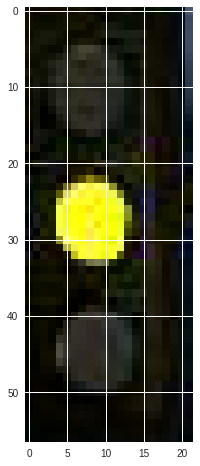

In [243]:
  ymin = boxes[0,0] 
  xmin = boxes[0,1] 
  ymax = boxes[0,2] 
  xmax = boxes[0,3] 

  (im_width, im_height) = image.size
  # im_width *= 0.9
  # im_height *= 0.9
  (xminn, xmaxx, yminn, ymaxx) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  cropped_image = tf.image.crop_to_bounding_box(image_np, int(yminn), int(xminn),int(ymaxx - yminn), int(xmaxx - xminn))
  sess = tf.Session()
  img_data = sess.run(cropped_image)
  sess.close()

  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(img_data)

In [244]:
r = img_data[:,:,0] > 100
g = img_data[:,:,1] > 100



print(sum(sum(r)))
print(sum(r[g]))
print(sum(sum(g)))


90
89
89
